# Meera's Final Notebook: putting everything together!

### Before running this notebook:
- create Task_2_Image_Localization/post-event-images

In [2]:
# importing everything

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.mask
from pyproj import Transformer
import shapely
from shapely.geometry import Polygon
from shapely.geometry import box

In [50]:
# setting up the figsize so that we don't have to keep entering it when plotting

plt.rcParams['figure.figsize'] = (10, 10)

In [53]:
post_hurricane_gpd = gpd.read_file('post-event-game-grid.geojson')

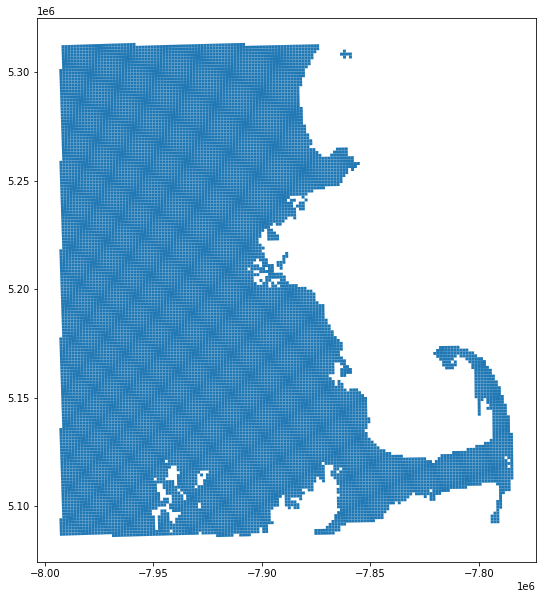

In [51]:
# visualizing the game grid

ax = post_hurricane_gpd.plot()

In [5]:
# view the columns of this dataframe

post_hurricane_gpd.head(1)

MGRS kmSQ_ID  GZD   EASTING   NORTHING MGRS_10km  Shape_Leng  \
0  19TBH7264      BH  19T  272000mE  4764000mN   19TBH76    0.042522   

   Shape_Le_1  Shape_Area  x_centroid  y_centroid  Health  Utility  Transport  \
0    0.042522     0.00011  -71.791007   42.999142       9        7          3   

   population     SVI                                           geometry  
0        15.0  0.2113  POLYGON ((-7991033.712 5311179.522, -7992397.7...

## DEM

In [54]:
# bounds of the game grid

game_grid_bounds = post_hurricane_gpd.to_crs('epsg:4326').total_bounds
west = game_grid_bounds[0]
south = game_grid_bounds[1]
east = game_grid_bounds[2]
north = game_grid_bounds[3]
game_grid_bounds

array([-71.80631774,  41.49541438, -69.92504326,  43.01057361])

In [58]:
# reading in the set of DEMs for the game grid

filepath = pd.read_csv('post-event-dems.csv')
filepath

sourceId        extent sourceOriginName  \
0  5deb32c9e4b02caea0f0ebbb  1 x 1 degree              gda   
1  5deb32c9e4b02caea0f0ebbd  1 x 1 degree              gda   
2  5deb32b8e4b02caea0f0eb4d  1 x 1 degree              gda   
3  5deb32b8e4b02caea0f0eb4f  1 x 1 degree              gda   
4  5deb32dbe4b02caea0f0ec2d  1 x 1 degree              gda   
5  5deb32b8e4b02caea0f0eb4b  1 x 1 degree              gda   
6  5deb32dbe4b02caea0f0ec2f  1 x 1 degree              gda   
7  5deb32dae4b02caea0f0ec2b  1 x 1 degree              gda   

                                         boundingBox  sizeInBytes  \
0  {minY:41.9994444436071,minX:-71.0005555562932,...    128354699   
1  {minY:41.9994444436071,minX:-72.0005555560934,...    489616162   
2  {minY:40.999444443807,minX:-71.0005555562932,m...    168352354   
3  {minY:40.999444443807,minX:-72.0005555560934,m...    301588789   
4  {minY:42.9994444434072,minX:-71.0005555562932,...    328027593   
5  {minY:40.999444443807,minX:-70.0005555564931,m...     18645141   
6  {minY:42.9994444448,minX:-72.0005555552,maxY:4...    468192000   
7  {minY:42.9994444443066,minX:-70.0005555555937,...     70323753   

   bestFitIndex   format                                        downloadURL  \
0      0.283969  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
1      0.229785  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
2      0.102182  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
3      0.082685  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
4      0.003214  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
5      0.002927  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
6      0.002601  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
7      0.000092  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   

                                   previewGraphicURL prettyFileSize  \
0  https://prd-tnm.s3.amazonaws.com/StagedProduct...      122.41 MB   
1  https://prd-tnm.s3.amazonaws.com/StagedProduct...      466.93 MB   
2  https://prd-tnm.s3.amazonaws.com/StagedProduct...      160.55 MB   
3  https://prd-tnm.s3.amazonaws.com/StagedProduct...      287.62 MB   
4  https://prd-tnm.s3.amazonaws.com/StagedProduct...      312.83 MB   
5  https://prd-tnm.s3.amazonaws.com/StagedProduct...       17.78 MB   
6  https://prd-tnm.s3.amazonaws.com/StagedProduct...      446.50 MB   
7  https://prd-tnm.s3.amazonaws.com/StagedProduct...       67.07 MB   

                                            datasets  \
0  [National Elevation Dataset (NED) 1/3 arc-seco...   
1  [National Elevation Dataset (NED) 1/3 arc-seco...   
2  [National Elevation Dataset (NED) 1/3 arc-seco...   
3  [National Elevation Dataset (NED) 1/3 arc-seco...   
4  [National Elevation Dataset (NED) 1/3 arc-seco...   
5  [National Elevation Dataset (NED) 1/3 arc-seco...   
6  [National Elevation Dataset (NED) 1/3 arc-seco...   
7  [National Elevation Dataset (NED) 1/3 arc-seco...   

                                      title  sourceOriginId lastUpdated  \
0  USGS 1/3 arc-second n43w071 1 x 1 degree        14451005  2020-03-03   
1  USGS 1/3 arc-second n43w072 1 x 1 degree        14457431  2020-03-03   
2  USGS 1/3 arc-second n42w071 1 x 1 degree        14451007  2020-03-03   
3  USGS 1/3 arc-second n42w072 1 x 1 degree        14643650  2020-03-03   
4  USGS 1/3 arc-second n44w071 1 x 1 degree        14451006  2020-03-03   
5  USGS 1/3 arc-second n42w070 1 x 1 degree        14451008  2020-03-03   
6   USGS 13 arc-second n44w072 1 x 1 degree        14429478  2020-03-03   
7   USGS 13 arc-second n44w070 1 x 1 degree        14429271  2020-03-03   

  dateCreated                                            metaUrl   sourceName  \
0  2019-12-06  https://www.sciencebase.gov/catalog/item/5deb3...  ScienceBase   
1  2019-12-06  https://www.sciencebase.gov/catalog/item/5deb3...  ScienceBase   
2  2019-12-06  https://www.sciencebase.gov/catalog/item/5deb3.

In [59]:
# downloading each DEM

for idx, path in enumerate(filepath['downloadURL']):
    urllib.request.urlretrieve(path, 'post-event-images/dem-orig-{}.tif'.format(idx))
print('Done!')

Done!


In [60]:
%%bash

# creating each elevation map from the DEMs

for i in {0..7}; do
    /opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-$i.tif post-event-images/dem-hs-$i.tif
done

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [1]:
# function for visualizing one of the elevation maps
# TO BE USED WHEN VISUALIZING FINAL PRODUCT

def remove_oceans(orig_path, hs_path, gdf = 'none'):
    with rasterio.open(orig_path, 'r') as src:
        orig = src.read(1)
        orig_mask = src.read_masks(1)
        orig_transform = src.profile['transform']

        final_mask = np.ma.masked_where(orig_mask==0, orig)

        with rasterio.open(hs_path, 'r') as src2:
            hs = src2.read(1)
            hs_mask = src2.read_masks(1)
            hs_transform = src2.profile['transform']
            fig, ax = plt.subplots(1,figsize = (10,10))
            final_hs = np.ma.masked_where(hs_mask == 0, hs)
            final_hs = np.ma.masked_where(final_mask == 0, final_hs)

            if (gdf != 'none'):
                gdf.plot(alpha=1, color='black', ax=ax)
            
            rasterio.plot.show(final_hs, transform=hs_transform, ax=ax)

        plt.show() 

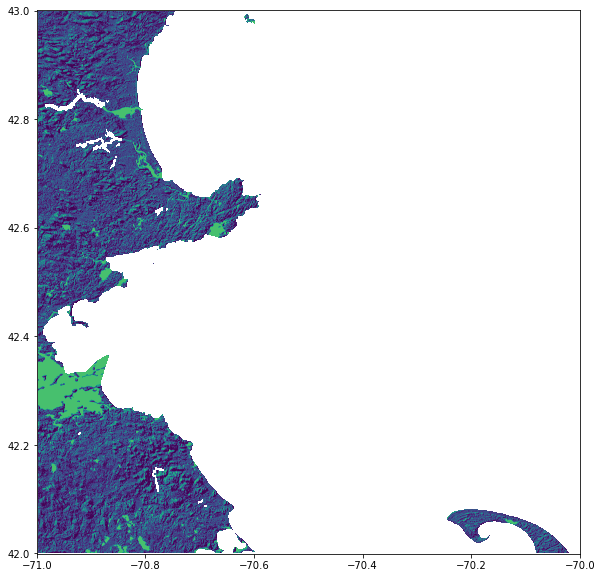

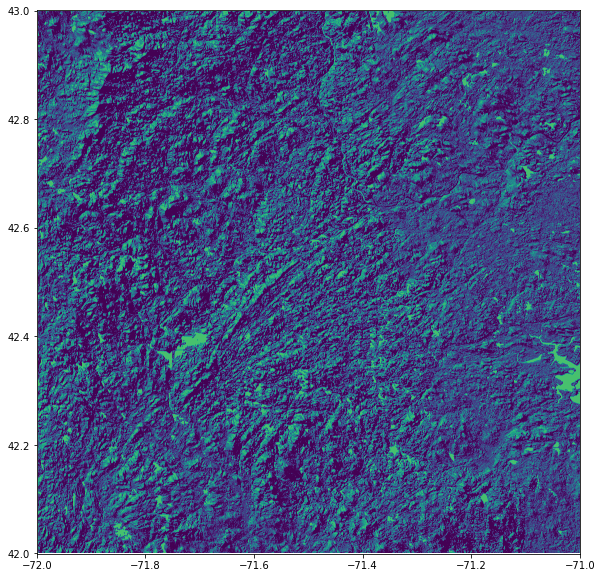

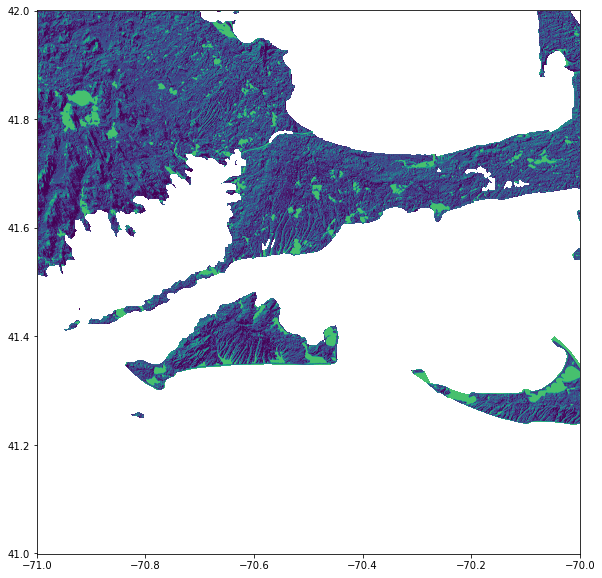

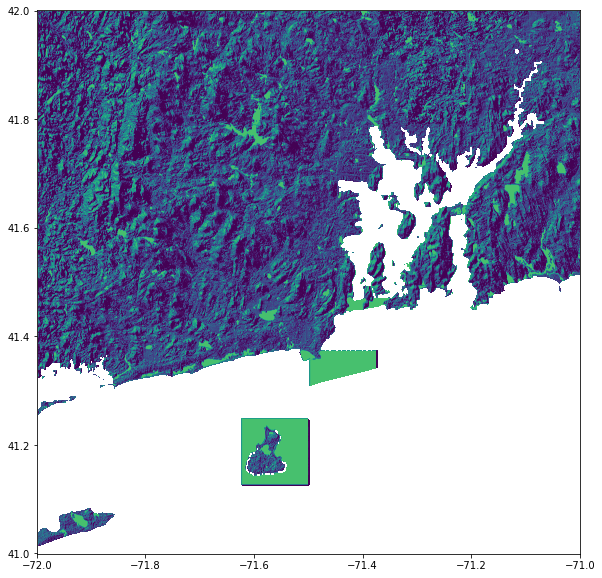

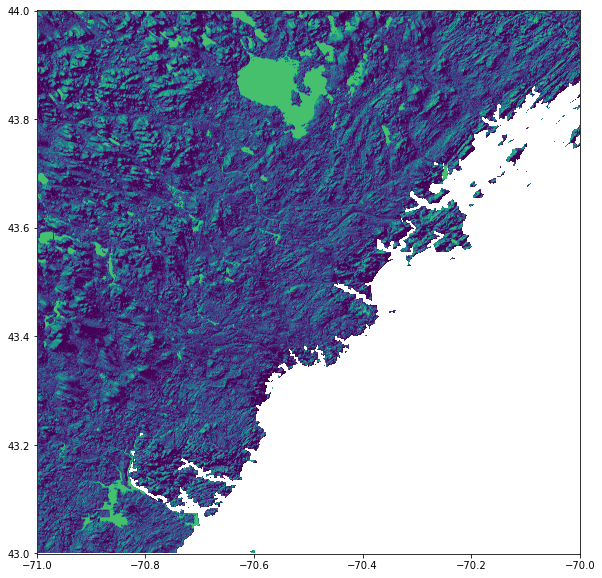

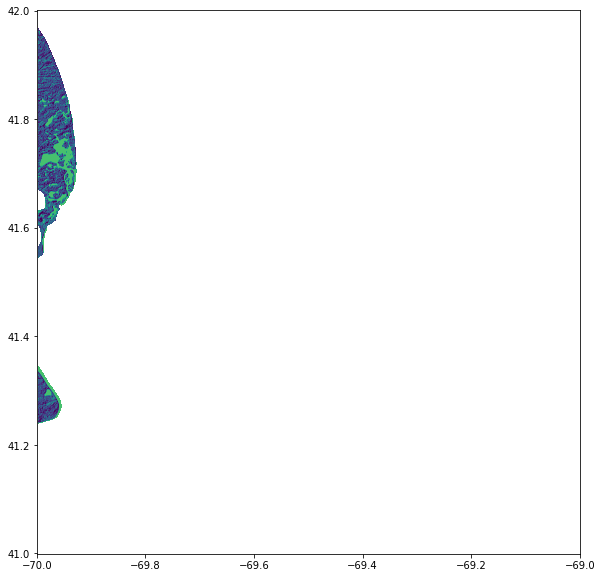

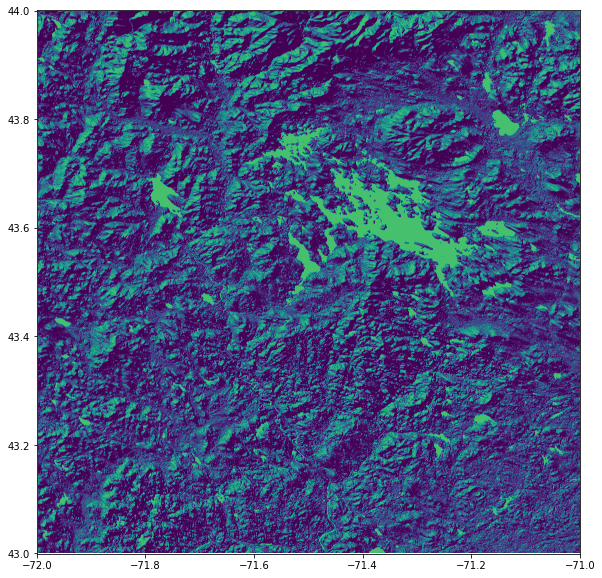

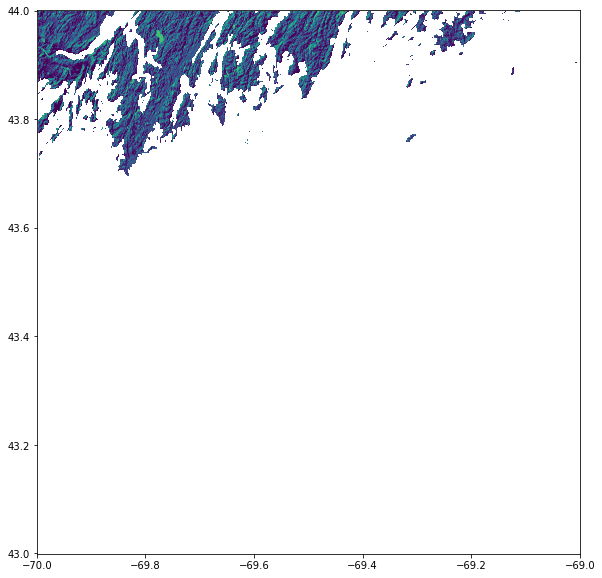

In [5]:
# plotting all of the individual DEMs (sanity check)

for idx in range(8): # these indices reference the images with ocean
    orig_path = 'post-event-images/dem-orig-{}.tif'.format(idx)
    hs_path = 'post-event-images/dem-hs-{}.tif'.format(idx)
    remove_oceans(orig_path, hs_path)

In [61]:
# creating low-resolution versions of each DEM
# (necessary to create full MA DEM)

rescaling_factor = 0.25
for idx in range(8):
    with rasterio.open('post-event-images/dem-orig-{}.tif'.format(idx)) as src:
        new_height = int(src.height*rescaling_factor)
        new_width = int(src.width*rescaling_factor)
        tile1 = src.read(1, out_shape=(new_height, new_width), 
                       resampling=rasterio.enums.Resampling.bilinear)
        tile1_profile = src.profile
        tile1_profile['transform'] = src.transform * src.transform.scale((src.width/tile1.shape[-1]),
                                                            (src.height/tile1.shape[-2]))
        tile1_profile['height'] = new_height
        tile1_profile['width'] = new_width
        
        with rasterio.open('post-event-images/dem-orig-lowres-{}.tif'.format(idx), 'w', **tile1_profile) as outfile:
            outfile.write(tile1, 1)
        
for idx in range(8):
    with rasterio.open('post-event-images/dem-hs-{}.tif'.format(idx)) as src:
        new_height = int(src.height*rescaling_factor)
        new_width = int(src.width*rescaling_factor)
        tile2 = src.read(1, out_shape=(new_height, new_width), 
                       resampling=rasterio.enums.Resampling.bilinear)
        tile2_profile = src.profile
        tile2_profile['transform'] = src.transform * src.transform.scale((src.width/tile2.shape[-1]),
                                                            (src.height/tile2.shape[-2]))
        tile2_profile['height'] = new_height
        tile2_profile['width'] = new_width
        
        with rasterio.open('post-event-images/dem-hs-lowres-{}.tif'.format(idx), 'w', **tile2_profile) as outfile:
            outfile.write(tile2, 1)

print('Done!')

Done!


In [62]:
# combining all low-res hillshades into the full MA DEM

with rasterio.open('post-event-images/dem-orig-lowres-0.tif', 'r') as src0,\
    rasterio.open('post-event-images/dem-orig-lowres-1.tif', 'r') as src1,\
    rasterio.open('post-event-images/dem-orig-lowres-2.tif', 'r') as src2,\
    rasterio.open('post-event-images/dem-orig-lowres-3.tif', 'r') as src3,\
    rasterio.open('post-event-images/dem-orig-lowres-4.tif', 'r') as src4,\
    rasterio.open('post-event-images/dem-orig-lowres-5.tif', 'r') as src5,\
    rasterio.open('post-event-images/dem-orig-lowres-6.tif', 'r') as src6,\
    rasterio.open('post-event-images/dem-orig-lowres-7.tif', 'r') as src7:
        
    combined, out_transform = rasterio.merge.merge([src0, src1, src2, src3, 
                                                    src4, src5, src6, src7],
                                                   nodata=src7.profile['nodata'])
    combined_meta = src0.profile.copy()
    combined_meta.update({'driver':'GTiff',
                     'count': combined.shape[0],
                    'height': combined.shape[1],
                    'width': combined.shape[2],
                    'transform': out_transform,
                    'crs': src1.crs})
    with rasterio.open('post-event-images/full-ma-orig.tif', 'w', **combined_meta) as dst:
        dst.write(combined)

with rasterio.open('post-event-images/dem-hs-lowres-0.tif', 'r') as src0,\
    rasterio.open('post-event-images/dem-hs-lowres-1.tif', 'r') as src1,\
    rasterio.open('post-event-images/dem-hs-lowres-2.tif', 'r') as src2,\
    rasterio.open('post-event-images/dem-hs-lowres-3.tif', 'r') as src3,\
    rasterio.open('post-event-images/dem-hs-lowres-4.tif', 'r') as src4,\
    rasterio.open('post-event-images/dem-hs-lowres-5.tif', 'r') as src5,\
    rasterio.open('post-event-images/dem-hs-lowres-6.tif', 'r') as src6,\
    rasterio.open('post-event-images/dem-hs-lowres-7.tif', 'r') as src7:
            
    combined, out_transform = rasterio.merge.merge([src0, src1, src2, src3, 
                                                    src4, src5, src6, src7],
                                                   nodata=src7.profile['nodata'])
    combined_meta = src0.profile.copy()
    combined_meta.update({'driver':'GTiff',
                     'count': combined.shape[0],
                    'height': combined.shape[1],
                    'width': combined.shape[2],
                    'transform': out_transform,
                    'crs': src1.crs})
    with rasterio.open('post-event-images/full-ma-hs.tif', 'w', **combined_meta) as dst:
        dst.write(combined)

print('Done!')

Done!


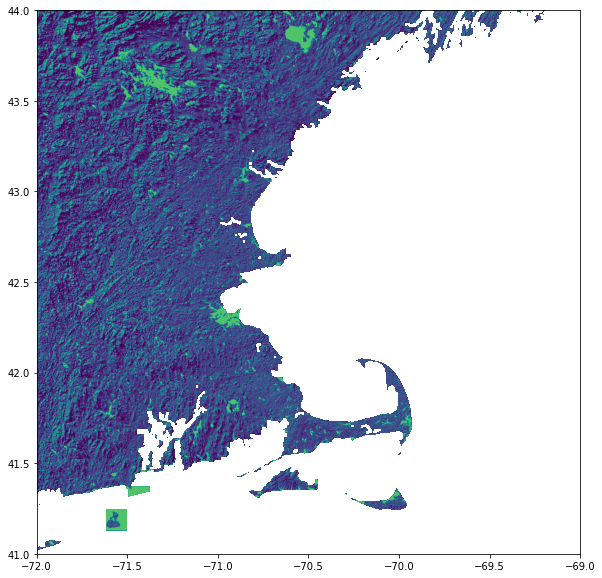

In [46]:
# plotting the full MA DEM (sanity check)

remove_oceans('post-event-images/full-ma-orig.tif', 'post-event-images/full-ma-hs.tif')

In [63]:
# cropping the current map so that it only shows the game grid

game_grid = shapely.geometry.box(west, south, east, north)
game_grid = Polygon(game_grid.exterior.coords)
shapes = [game_grid]

with rasterio.open('post-event-images/full-ma-orig.tif', 'r') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_profile = src.profile
    out_profile.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("post-event-images/cropped-ma-orig.tif", "w", **out_profile) as masked_outfile:
    masked_outfile.write(out_image)

with rasterio.open('post-event-images/full-ma-hs.tif', 'r') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_profile = src.profile
    out_profile.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("post-event-images/cropped-ma-hs.tif", "w", **out_profile) as masked_outfile:
    masked_outfile.write(out_image)

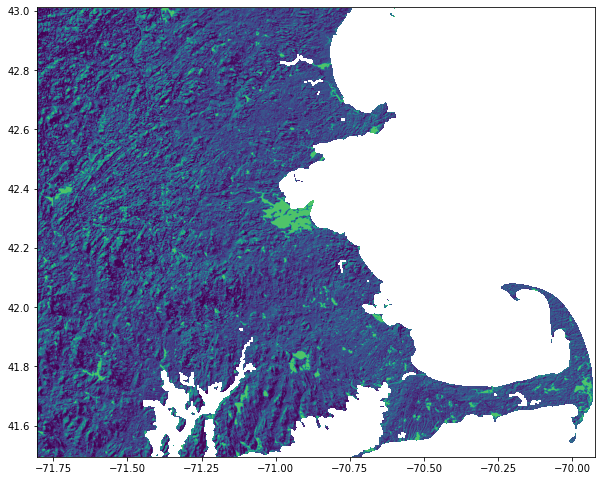

In [64]:
# visualizing the game grid in 3D!

remove_oceans('post-event-images/cropped-ma-orig.tif', 'post-event-images/cropped-ma-hs.tif')

## OSM

### Roads

In [ ]:
# getting the roads in the affected area from open street maps

x = 0.5 # a buffer in case the normal bounds take too much memory
roads = ox.graph_from_bbox(north-x, south+x, east-x, west+x)
roads

In [ ]:
# converting the roads graph into a geodataframe that we can plot
# (roads_nodes is just a placeholder; may come in handy later)

roads_nodes, roads_gdf = ox.graph_to_gdfs(roads)

In [ ]:
# just taking the primary roads; otherwise the map gets VERY crowded

roads_prim = roads_gdf.loc[roads_gdf['highway']=='primary']

In [ ]:
# visualizing the primary roads on the game grid (sanity check)

# !if remove_oceans doesn't work, copy-paste the function code into this cell
# and replace the gdf.plot line with:
# roads_prim.plot(alpha=1, color='black', ax=ax)

remove_oceans('post-event-images/cropped-ma-orig.tif', 'post-event-images/cropped-ma-hs.tif', gdf=roads_prim)

### CAP Imagery Points

In [ ]:
# loading in CAP imagery dataset for affected area

gdf = gpd.GeoDataFrame(hurricane_imgs, geometry=gpd.points_from_xy(hurricane_imgs.gps_lon, hurricane_imgs.gps_lat))
gdf

In [ ]:
# visualizing the CAP imagery points on the game grid

# !if remove_oceans doesn't work, copy-paste the function code into this cell
# and replace the gdf.plot line with:
# gdf.plot(figsize=(10, 350), alpha=.5, color='red', ax=ax)

remove_oceans('post-event-images/cropped-ma-orig.tif', 'post-event-images/cropped-ma-hs.tif', gdf=gdf)